In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from glob import glob
from src import train_to_implicit, implicit_to_species_aggregate
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
train_data = pd.read_csv("../data/train_images.csv")
class_names =  np.load("../data/class_names.npy", allow_pickle=True)

In [3]:
subspecies = {v: k.split(".")[-1] for k, v in class_names.item().items()}
species = {vs: [k for k, v in subspecies.items() if vs in v] for vs in set([x.split("_")[-1] for x in subspecies.values()])}

In [4]:
sorted_bird_dict = dict(sorted(species.items(), key=lambda x: len(x[1])))
start_key = "Tern"
end_key = "Warbler"
sliced_bird_dict = {key: species[key] for key in species if start_key <= key <= end_key}

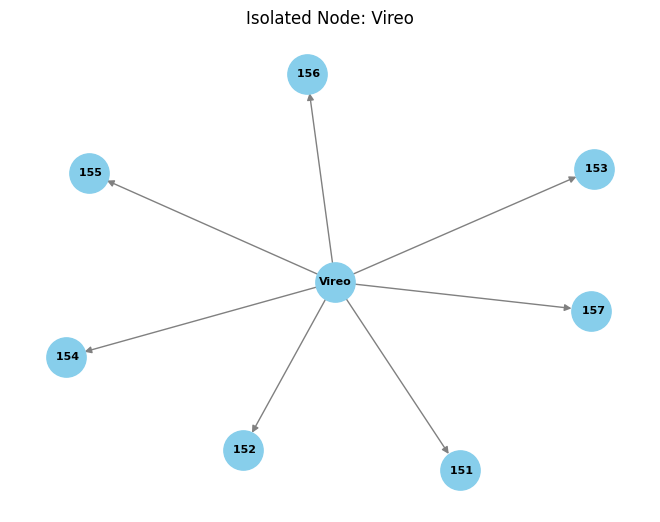

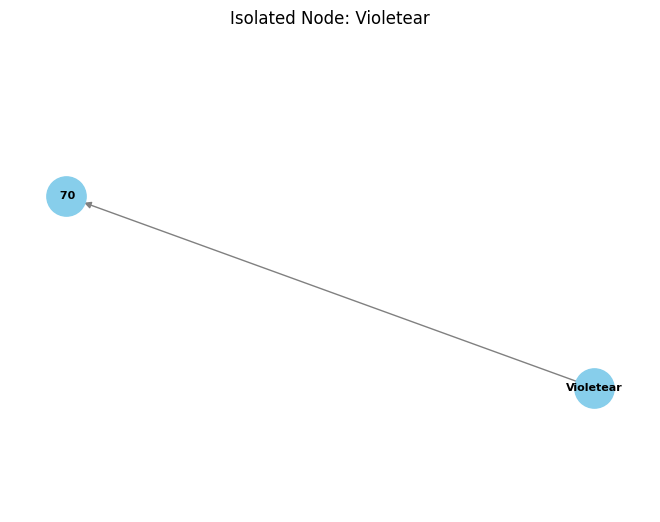

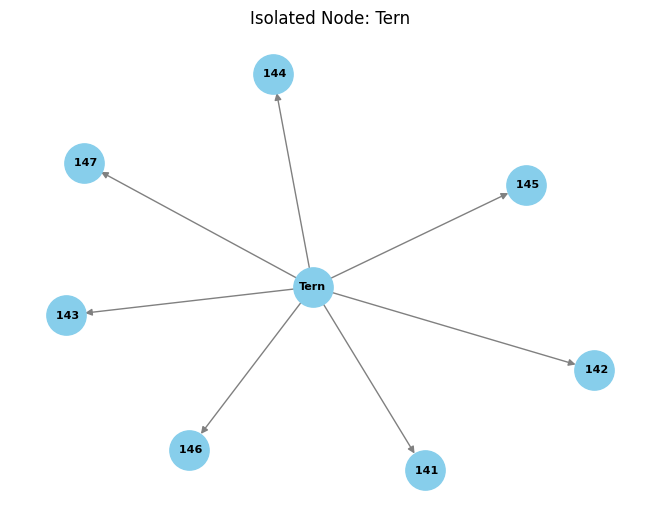

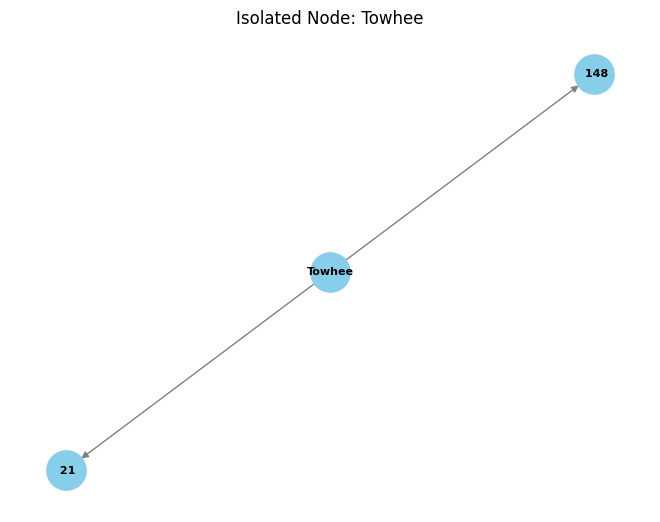

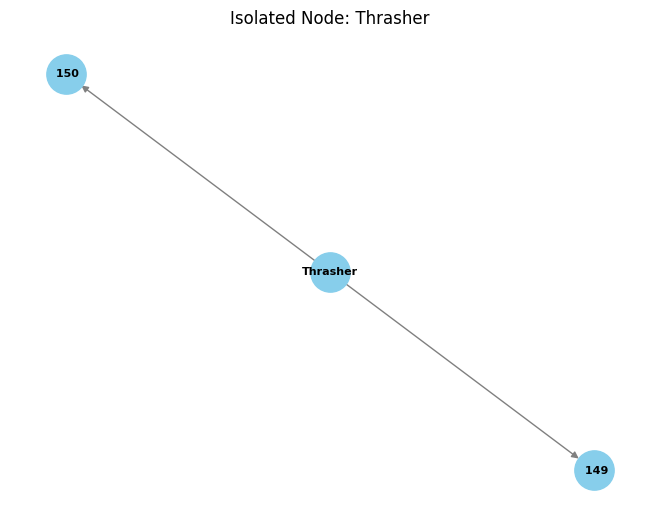

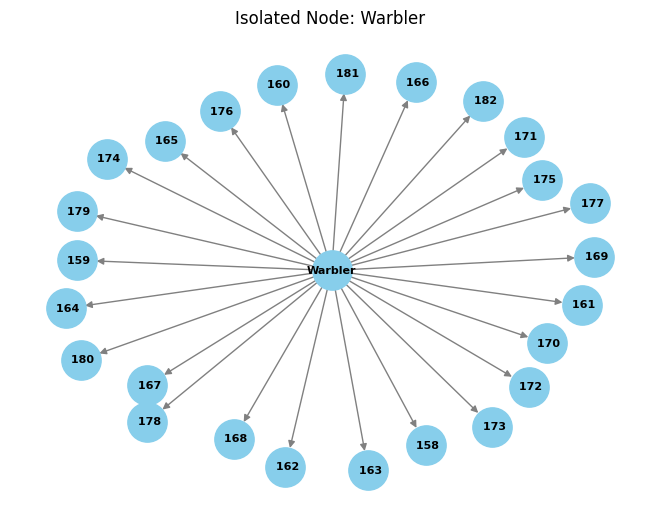

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for species_x, relations in sliced_bird_dict.items():
    G.add_node(species_x)
    for relation in relations:
        G.add_edge(species_x, f' {relation}')

character_nodes = [node for node in G.nodes if not node.startswith(' ')]

# Isolate each node and visualize
for node in character_nodes:
    subgraph = G.subgraph([node] + list(G.neighbors(node)))
    pos = nx.spring_layout(subgraph, weight=5, scale=0.01)
    nx.draw(subgraph, pos, with_labels=True, font_weight='bold', node_size=800, node_color='skyblue', font_size=8, edge_color='gray')
    # Add a title with the current node's name
    plt.title(f'Isolated Node: {node}')
    # Show the plot for each isolated node
    plt.show()

## Get Class Distribution

C:\Users\Oliver\AppData\Local\Temp\ipykernel_8988\4058448287.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subspecies.values(), rotation=60)


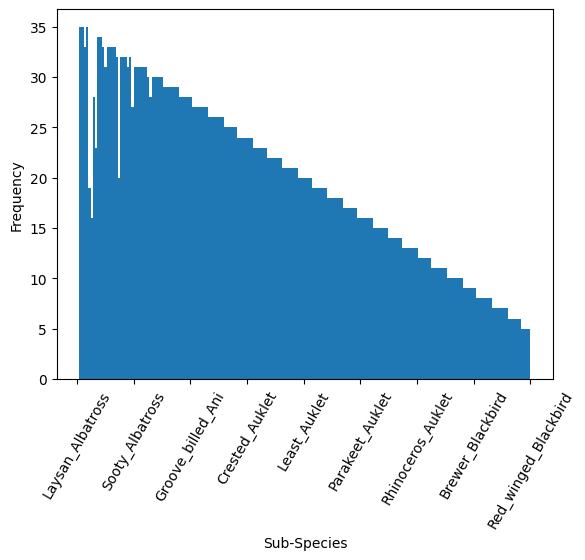

In [6]:
fig, ax = plt.subplots(1,1)
ax.hist(train_data.label, bins=len(subspecies))
ax.set_ylabel("Frequency")
ax.set_xlabel("Sub-Species")
ax.set_xticklabels(subspecies.values(), rotation=60)

plt.show()

## Check Image Properties

In [10]:
widths = []
heights = []

for img in glob("../data/train_images/train_images/**.jpg"):
    im = Image.open(img)
    widths.append(im.size[0])
    heights.append(im.size[1])

AVG_HEIGHT = round(sum(heights)/len(heights))
AVG_WIDTH = round(sum(widths)/len(widths))

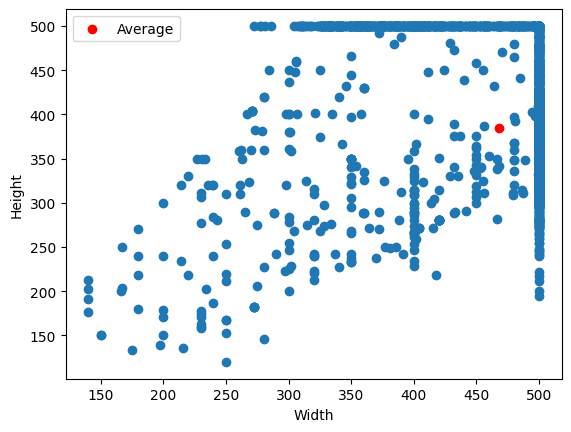

In [11]:
plt.scatter(widths, heights)
plt.scatter(AVG_WIDTH, AVG_HEIGHT, color="r", label="Average")
plt.xlabel("Width")
plt.ylabel("Height")
plt.legend()
plt.show()

## Process Data

In [12]:
# make subspecies into implicit folder structure (for tf pipeline)
train_to_implicit("../data/train_images/train_images", train_data)

100%|██████████| 200/200 [00:00<00:00, 3448.57it/s]


In [13]:
# aggregate implicit folder structure to species structure
implicit_to_species_aggregate("../data/train_images/train_images", species)

100%|██████████| 70/70 [00:06<00:00, 10.10it/s]


In [ ]:
with open("mapping.pickle", "wb+") as f: 
    pickle.dump(species, f)